In [8]:
# packages
download_required = False

if download_required:
    !pip install nltk
    !pip install seaborn
    !pip install scipy.stats
    !pip install multiprocess # allows for multiple processes in jupyter notebooks
else:
    pass

## Technical packages 
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import time
import random
import pandas as pd
import itertools
import scipy.stats
import math
import seaborn as sns
import re
from IPython.display import display_html 

## Language packages
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg
from nltk.corpus import stopwords

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})



In [9]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /Users/luca/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

# Introduction
Similarity analysis is a technique used to measure the similarity or distance between two or more items or sets. Jaccard similarity and cosine similarity are two common methods used for calculating the similarity between two sets. Two well-defined methods for similarity analysis are:

- Jaccard similarity, also known as the Jaccard coefficient, is a measure of the similarity between two sets based on the size of their intersection and union. It is defined as the size of the intersection divided by the size of the union of the sets. 

- Cosine similarity, on the other hand, is a measure of similarity between two vectors based on the angle between them. It is defined as the dot product of the vectors divided by the product of their magnitudes. Cosine similarity is often used to compare vectors of continuous data, such as word embeddings in natural language processing tasks.

Both Jaccard similarity and cosine similarity are widely used in various fields, including data mining, machine learning, and natural language processing, to measure the similarity between items or sets and enable comparison and analysis of data. For example, they can be used to identify similar documents in a collection, to recommend items to users based on their past preferences, or to cluster data into groups based on similarity. This report intends to analyse differences in runtime for different similarity measures for documents. The report will be structured in the following sections:

1) Analysis of the runtime of Jaccards similarity measure for documents larger than 50 words represented as bags of words.
2) Analysis of the runtime of Cosine similarity measure for documents larger than 50 words represented as dense vectors without the use of `np.dot()`.
3) Analysis of the runtime of Cosine similarity measure for documents larger than 50 words represented as dense vectors **with** the use of `np.dot()`.
4) Analysis of the runtime of Cosine similarity measure for documents larger than 50 words represented as bag of words representations. 
5) Analysis of the runtime of all-pairs comparisons for more than 10 documents using either of the three different similarity measures analysed in 1 - 4.
6) Analysis of the runtime of all-pairs comparisons for more than 10 documents using a multiprocessing paradigm (here: MapReduce)

Note: local machine: (MacBook Pro, 2,4 GHz 8-Core Intel Core i9, 32 GB 2667 MHz DDR4)

# Section 0: Word Generation and Function Explanations

In the following section all generic functions that are being used in this report will be listed and their functionality will be explained. This report did not rely on real documents for its analysis. Instead, it used a class `DocumentCreator` to produce documents or pairs of documents that were then used in the analysis. This proceedure was selected to increase the control over the experimental space. For the purposes of this report in section 1 to 4 the documents created are always unique of each other adn their similarity to each other will be zero. In section 5 and section 6 the documents created are increasing and length and decreasing in similiarity. For the first part of the assignment, this has been achieved by indexing and set of words (ca. 50k) form the beginning and the end to always generate unique documents. For the second part of the assignment, the list is indexed from the beginning but a random integer value between 1 and 10 is added. As a result the experimental space is well defined. The following cells are the class that create the orginal word list as well as the timeit function and tokenize function (create bag of words representations). The original sorce is the gutenberg corpus from the nltk package. Other languages can be used in the process. Stopwords and puctioation have been removed. 

In [10]:
class CreateDocument:
    def __init__(self, corpus= gutenberg):
        self.word_list = list(set(corpus.words())) # allows for different corpi to be used for word generation


    def return_word_list(self):
        return self.remove_punctuation(self.word_list)


    @staticmethod
    def remove_punctuation(word_list: list):
        '''
        Removes punctuation from a list of words as well as lowers all words to make them more formalized. In addition, 
        all filler words from the stopwords.words('english') are being removed.
        '''
        filtered_list = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in word_list]
        filtered_list = list(filter(None, filtered_list))
        filtered_list = [x.lower() for x in filtered_list]
        filtered_list = [x for x in filtered_list if x not in set(stopwords.words('english'))]
        return filtered_list
        

def timeit(somefunc, *args, repeats=100,**kwargs):
    '''
    The function is used to time the runtime of a fuction averaged over multiple iterations. The number of repeats can be specified.
    '''

    times=[]
    
    #excute function for the given repeats, timing the execution and obtaining the mean
    while repeats>0:
        starttime=time.time()
        ans=somefunc(*args,**kwargs)
        endtime=time.time()
        timetaken=endtime-starttime
        times.append(timetaken)
        repeats-=1
    
    mean=np.mean(times)
    stdev=np.std(times)
    error=stdev/(len(times)**0.5)
 
    return (ans,mean,error)

def tokenize(l: list):
        '''
        Tokenizes a list of words into a dictionary of counts of words (bag of words representation).
        '''
        tokenized_dict = {}
        for i in range(len(l)):
            if l[i] in tokenized_dict:
                pass
            else:
                tokenized_dict[l[i]] = l.count(l[i])
            

        return tokenized_dict

In [11]:
DocumentObject = CreateDocument()
filtered_list = DocumentObject.return_word_list()

## NOTE: 
In the following analyses documents are being created ranging from 400 to 5000 words, These documents are the tokenized and (for the dense cosine similarity) subsequently coverted into vectors. No document has any overlap as the original list is a set of ca. 50000 unique words. Therefore the similarity between the documents is always 0. This proceedure was selected to remove any potential issues and create a level playing field for all algorithms. Rerunning the cells will change the values slightly, but the general idea will be the same. 

# Section 1: Jaccards Similarity for bags of words representations

Mathmatically the Jaccard Similarity is defined as follows:

$$J(A,B) = \frac{|A \cap B|}{|A \cup B|}$$

## Analysis of the Jaccards Similarity Algorithm

In [12]:
#################################################################################
# Functions for Analysis 1: Jaccards Similarity for bags of words representations
#################################################################################

def maketotal(dict_1):
    '''
    calculate the total number of words in a dictionary
    '''
    total = 0
    for item in dict_1:
        total += dict_1[item]
    return total  


def Jaccards(dict_1, dict_2):
    '''
    calculates the Jaccards Similarity between two dictionaries
    '''
    intersection = {} 
    for item in dict_1.keys():
        if item in dict_2.keys():
            intersection[item]=min(dict_1[item],dict_2[item])
            
    intersectiontot = maketotal(intersection)
    union = maketotal(dict_1) + maketotal(dict_2) - intersectiontot
    
    return intersectiontot/union


### Explanation and theoretical worst case runtime

The intersection of the sets divided by their union is used by the Jaccards measure to analyse how similar two sets are to one another. The scale for the similarity is 0 to 1, with 1 denoting complete identity between the sets and 0 denoting no resemblance at all. The union divides three processes at their intersection. For the algorithm above we get the following analysis of its runtime:

$$\begin{aligned} &\text{line 1: assigning of object} = O(1) \\ &\text{line 2: for-loop through dictionary keys} = O(n) \\ &\text{line 3: if-condition for keys} = O(1) \\ &\text{line 4: assigning value to intersection object} = O(1) \\ & \text{line 4: assigning value to intersection object} = O(1) \\ &\text{line 5: calling of function maketotal with TC O(n)} = O(n) \\ &\text{line 6: assigning results of maketotal} = O(n) \\ &\text{line 7: return final value} = O(1) \end{aligned} $$

Hence, the theoretical worst case runtime of the algorithm is $O(n)$ where n is the number of elements that are being input into the algorithm. One noteworthy feature of the algorithm is that line 3 is only $O(1)$ because the dictionary data structure in python is not $O(n)$ because it uses hash tables to find its values unlike a list that would require looping through each element, thereby increasing the theoretical worst case time complexity of the algorithm to $O(n^2)$.

#### Final Time Complexity for the Jaccards similarity:
$$O(n)$$

## Emperical Analysis of the Time Complexity

In [13]:
#################################################################################
# Analysis 1: Jaccards Similarity for bags of words representations
#################################################################################

jac_xs = [x for x in range(400,5000,10)]
jac_ys = []


# the analysis takes documents between 400 and 5000 words in steps of 10 to get a good understanding of the theoretical worst case runtime. 
for i in range(400,5000,10): 
    size = i

    doc1 = filtered_list[:size] # create a doument with a length between 400 and 5000 words
    doc2 = filtered_list[-size:] # create a doument with a length between 400 and 5000 words; slicing form the end of the list gurantees different words to the first list

    doc1_tok = tokenize(doc1) # creates bag of words representations of the document
    doc2_tok = tokenize(doc2)


    jac_ys.append(timeit(Jaccards,doc1_tok,doc2_tok)[1]) # times the runtime of Jaccard Algorithms for the similarity analysis and stores it in a list. 

The empirical Analysis of the Jaccard Similarity has yielded a value of 1.028767633881394 for the slope and a value of 2.458799769349047e-16 for the computer constant.


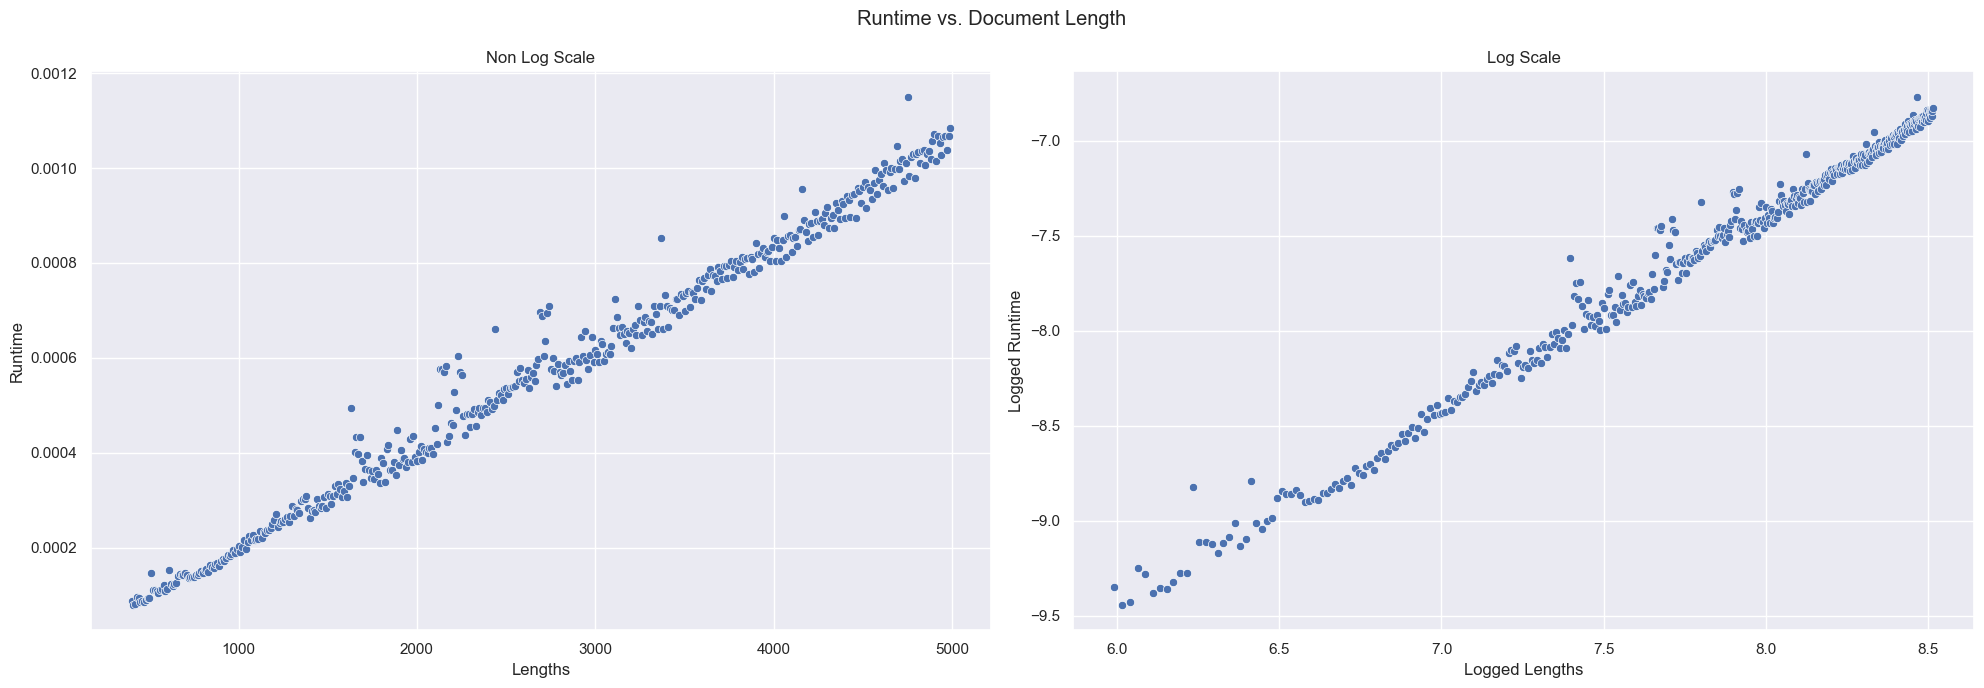

In [14]:
########################################################
# Plotting the results and summary staistics
########################################################
jac_logx = [np.log(x) for x in jac_xs]
jac_logy = [np.log(y) for y in jac_ys]


fig, axes = plt.subplots(1,2,figsize=(20,7),dpi=100)
fig.suptitle('Runtime vs. Document Length')

sns.scatterplot(ax=axes[0], x = jac_xs, y = jac_ys).set_title('Non Log Scale')
sns.scatterplot(ax=axes[1], x = jac_logx, y = jac_logy).set_title('Log Scale')

axes[0].set_ylabel('Runtime')
axes[1].set_ylabel('Logged Runtime')
axes[0].set_xlabel('Lengths')
axes[1].set_xlabel('Logged Lengths')
plt.tight_layout()


slope_jaccard,intercept, r_value, p_value ,std_err = scipy.stats.linregress(jac_logx,jac_logy)
computer_constant = np.power(10,intercept)

print(f'The empirical Analysis of the Jaccard Similarity has yielded a value of {slope_jaccard} for the slope and a value of {computer_constant} for the computer constant.')


## Analysis of the Results
The emperical analysis of the results confirms the theoretically calculated runtime for increases in the number of words per document. As can be seen from the graph above. The time it takes to calculate the Jaccard similarity grows linearly with the number of words in the document. Using statistical analysis it was shown that the time complexity in the experiment was $O(n^{1.028})$  (solving for $n$ in $log(y) = log(c_a) + n * log(x)$; right plot) which is very close to the theoretically time complexity of $O(n^1)$. The computer constant for this local machine (MacBook Pro, 2,4 GHz 8-Core Intel Core i9, 32 GB 2667 MHz DDR4) was calculated (solving for $c_a$ in $log(y) = log(c_a) + n * log(x)$) to be 2.458799769349047e-16. 

# Section 2: Cosine Similarity for dense vector representation:

Mathmatically the Cosine Similarity is defined as follows:

$$Cos(\theta) = \frac{\vec{A} \times \vec{B}}{\sqrt{\vec{A} \times \vec{A}}\times \sqrt{\vec{B} \times \vec{B}}}$$


## Analysis of the Cosine Similarity Algorithm for dense representations
In the following section, the cosine similarity algorithm for dense representations is analysed. In the first cells the basic function for converting sparse representations into dense representations as well as the cosine similarity algorithm is implemented.

In [15]:
#################################################################################
# Functions for Analysis 2: Cosine Similarity for dense vector representations
#################################################################################

def convert_to_vectors(doc1: dict, doc2: dict):
    '''
    Converts the documents into vectors representations.
    '''

    for i in range(len(doc1)):
        keys1 = list(doc1.keys())

    for i in range(len(doc2)):
        keys2 = list(doc2.keys())
    

        union = sorted(list(set(keys1 + keys2))) # creates the union of the two input dictionaries

        v1 = [] 
        v2 = [] 

        for j in range(len(union)):
            if union[j] in doc1.keys():
                v1.append(doc1[union[j]])
            else:
                v1.append(0)

        for j in range(len(union)):
            if union[j] in doc2.keys():
                v2.append(doc2[union[j]])
            else:
                v2.append(0)

        return np.asarray(v1), np.asarray(v2)



def naCosine(vector_1, vector_2):
    '''
    Naive implementation of cosine similarity.
    '''
    numerator = 0
    for i in range(len(vector_1)): # vectors are always of the same length as the they are constructed on their union, see function above.
        numerator += vector_1[i]*vector_2[i]

    norm_v1 = np.sqrt(np.sum(vector_1**2))
    norm_v2 = np.sqrt(np.sum(vector_2**2))

    denominator = norm_v1*norm_v2

    return round(numerator/denominator,6)


## Theoretical Analysis of the Algorithm

In contrast to the the Jaccards similarity algorithm, here the documents are represented as vectors. Each value in the vector is the frequency of the word in the document. When a document lacks a matching word from the comparison dictionary, zeros fill the space in the vector The length of the vectors is constant and resembles the length of the union of two documents.Based on this, the algorithm's worst-case runtime is equal to the length of the supplied vectors. 

### Systematic Breakdown of the Algorithm: 
The algorithm has a theoretical worst case runtime of O(n) which can be demostrated by braking the algorithm down into its individual components: 

$$\begin{aligned}

&\text{line 1: assigning of object} = O(1) \\ &\text{line 2: for-loop through vector} = O(n) \\ &\text{line 3: update object (line 1)} = O(1) \\ &\text{line 4: assigning value} = O(1) \\ & \text{line 4: assigning value } = O(1) \\ &\text{line 5: assign value} = O(1) \\ &\text{line 7: return final value} = O(1)

\end{aligned}$$

As can be seen from the theoretical breakdown of the algorithm. The only part of the algorithm that is not O(1) is the for-loop through the vector. Hence the runtime growns linearily with the size of the vector. 

## Final Time Complexity for the Cosine similarity:
$$O(n)$$

In [16]:
#################################################################################
# Analysis 2: Cosine Similarity for dense vector representations
#################################################################################

cos_xs = [x for x in range(400,5000,10)]
cos_ys = []

for i in range(400,5000,10):
    size = i

    doc1 = filtered_list[:size]
    doc2 = filtered_list[-size:]

    doc1_tok = tokenize(doc1)
    doc2_tok = tokenize(doc2)

    v1, v2 = convert_to_vectors(doc1=doc1_tok,doc2=doc2_tok)

    cos_ys.append(timeit(naCosine,v1,v2)[1])


The empirical Analysis of the Cosine Similarity without numpy has yielded a value of 0.978877274244178 for the slope and a value of 4.065293038834557e-15 for the computer constant.


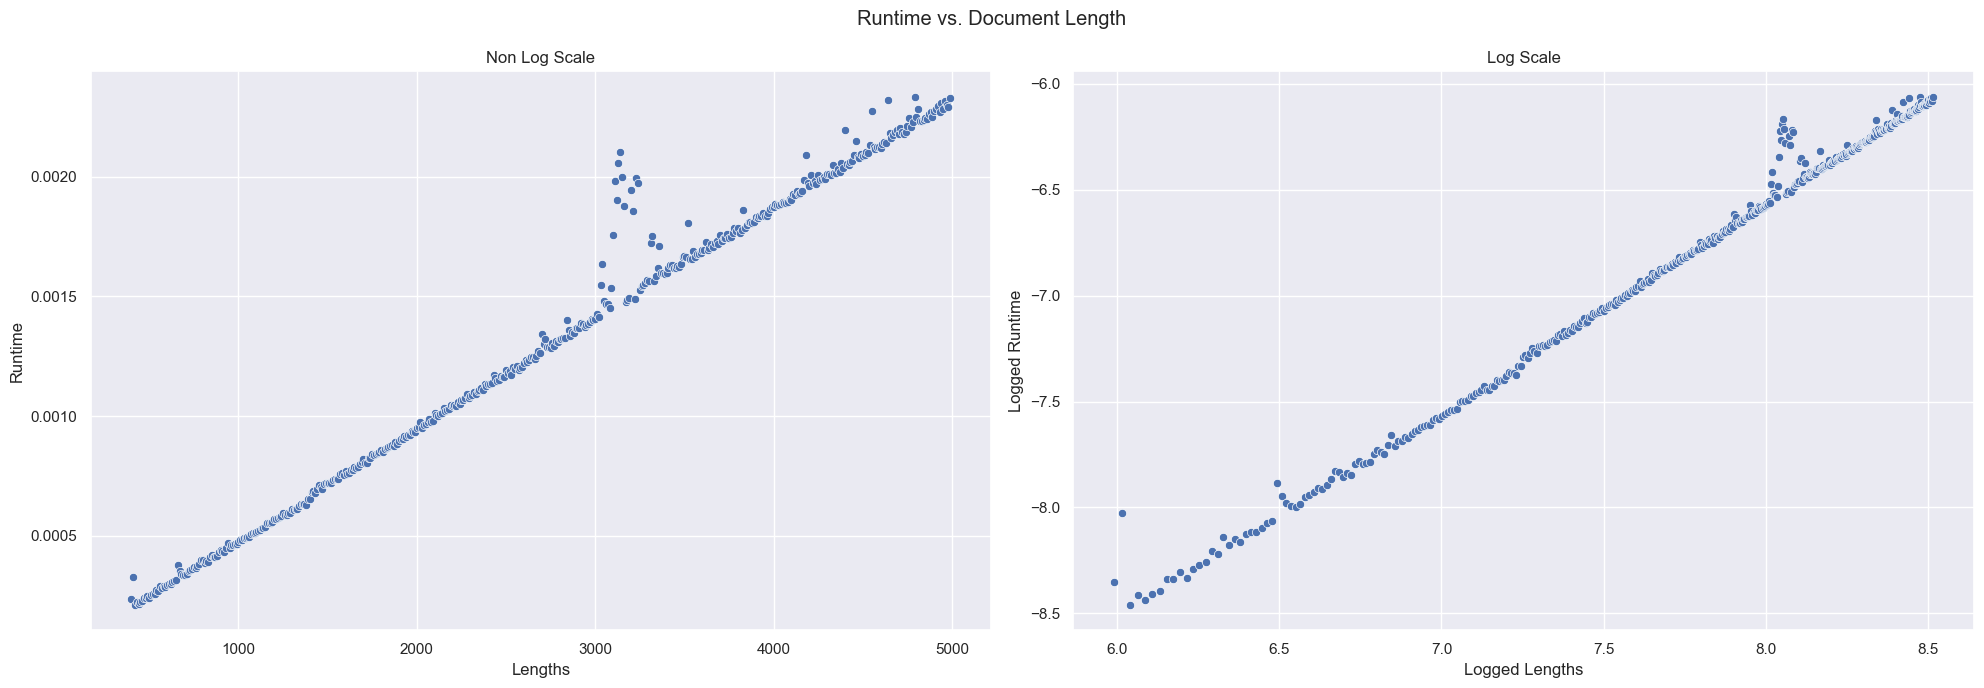

In [17]:
########################################################
# Plotting the results and summary staistics
########################################################

cos_logx = [np.log(x) for x in cos_xs]
cos_logy = [np.log(y) for y in cos_ys]


fig, axes = plt.subplots(1,2,figsize=(20,7),dpi=100)
fig.suptitle('Runtime vs. Document Length')

sns.scatterplot(ax=axes[0], x = cos_xs, y = cos_ys).set_title('Non Log Scale')
sns.scatterplot(ax=axes[1], x = cos_logx, y = cos_logy).set_title('Log Scale')

axes[0].set_ylabel('Runtime')
axes[1].set_ylabel('Logged Runtime')
axes[0].set_xlabel('Lengths')
axes[1].set_xlabel('Logged Lengths')
plt.tight_layout()


slope,intercept, r_value, p_value ,std_err = scipy.stats.linregress(cos_logx,cos_logy)
computer_constant = np.power(10,intercept)

print(f'The empirical Analysis of the Cosine Similarity without numpy has yielded a value of {slope} for the slope and a value of {computer_constant} for the computer constant.')



## Analysis of the results
Similarily to the Analysis of the Jaccard similarily the Cosine Similarily has a theoretical time complexity of $O(n)$. The empirical analysis of the algorithm conforms to the theoretical time complexity. As shown above, the empirical Analysis of the Cosine Similarity without Numpy has yielded a value of 0.978877274244178 for the slope and a value of 5.641156830265304e-15 for the computer constant. Therefore the time complexity of the cosine similarity is $O(n^{0.978})$.

# Section 3: Cosine Similarity for Dense Representations using Numpys `np.dot()`

In the following cells the same analysis as for the Cosine Similarity is conducted, howevver within the cosine function `numpy` function are being used for the calculations.

In [18]:
#################################################################################
# Functions for Analysis 3: Cosine Similarity with np.dot()
#################################################################################

def denominator(v1,v2):
    return np.sqrt(np.sum(v1)) * np.sqrt(np.sum(v2))


def cosine_np(v1,v2):
    num = np.dot(v1,v2)
    denom = denominator(v1,v2)

    cos = np.divide(num,denom)

    return round(cos,6)


## Analysis of the theoretical worst case runtime
The theoretical worst case runtime is again determined by deconstructing the algorithm used into its components. 

$$\begin{aligned} 
&\text{line 1: calculate dot product} = O(n) \\  
&\text{line 2: call function DENOMINATOR} = O(1) \\
&\text{line 3: assign value from division} = O(1) \\
&\text{line 4: return function} = O(1)

\end{aligned}$$ 

Identical to the algorithms analysed above, the theoretical determined runtime is $O(n)$. Hereby, it is noteworth that the function `np.dot` has a time complexity of $O(n)$. This is not immediately clear from the code. However, it makes logical sense as for the dot product, evert value of the one vector has to be multiplied by a value from the other vector. Hence every value needs to be called once and the time complexity is $O(n) instead of $O(1)$.

## Final Time Complexity for the Cosine similarity with `np.dot()`:
$$O(n)$$

In [19]:
#################################################################################
# Analysis 3: Cosine Similarity for dense vector representations with np.dot()
#################################################################################

# cos_np_xs = [x for x in range(400,10000,10)]
cos_np_ys = []

for i in range(400,5000,10):

    size = i

    doc1 = filtered_list[:size]
    doc2 = filtered_list[-size:]

    doc1_tok = tokenize(doc1)
    doc2_tok = tokenize(doc2)

    v1, v2 = convert_to_vectors(doc1=doc1_tok,doc2=doc2_tok)

    cos_np_ys.append(timeit(cosine_np,v1,v2)[1])


In the analysis documents are being created ranging from 400 to 5000 words, These documents are the tokenized and subsequently coverted into vectors. The vectors use its union as the size for the vector to make the analysis more efficient. No document has any overlap as the original list is a set of ca. 50000 unique words. Therefore the similarity between the documents is always 0. This proceedure was selected to remove any potential issues and create a level playing field for all algorithms. 

The empirical Analysis of the Cosine Similarity with Numpy has yielded a value of 0.09280978424101784 for the slope and a value of 5.666576152416905e-12 for the computer constant.


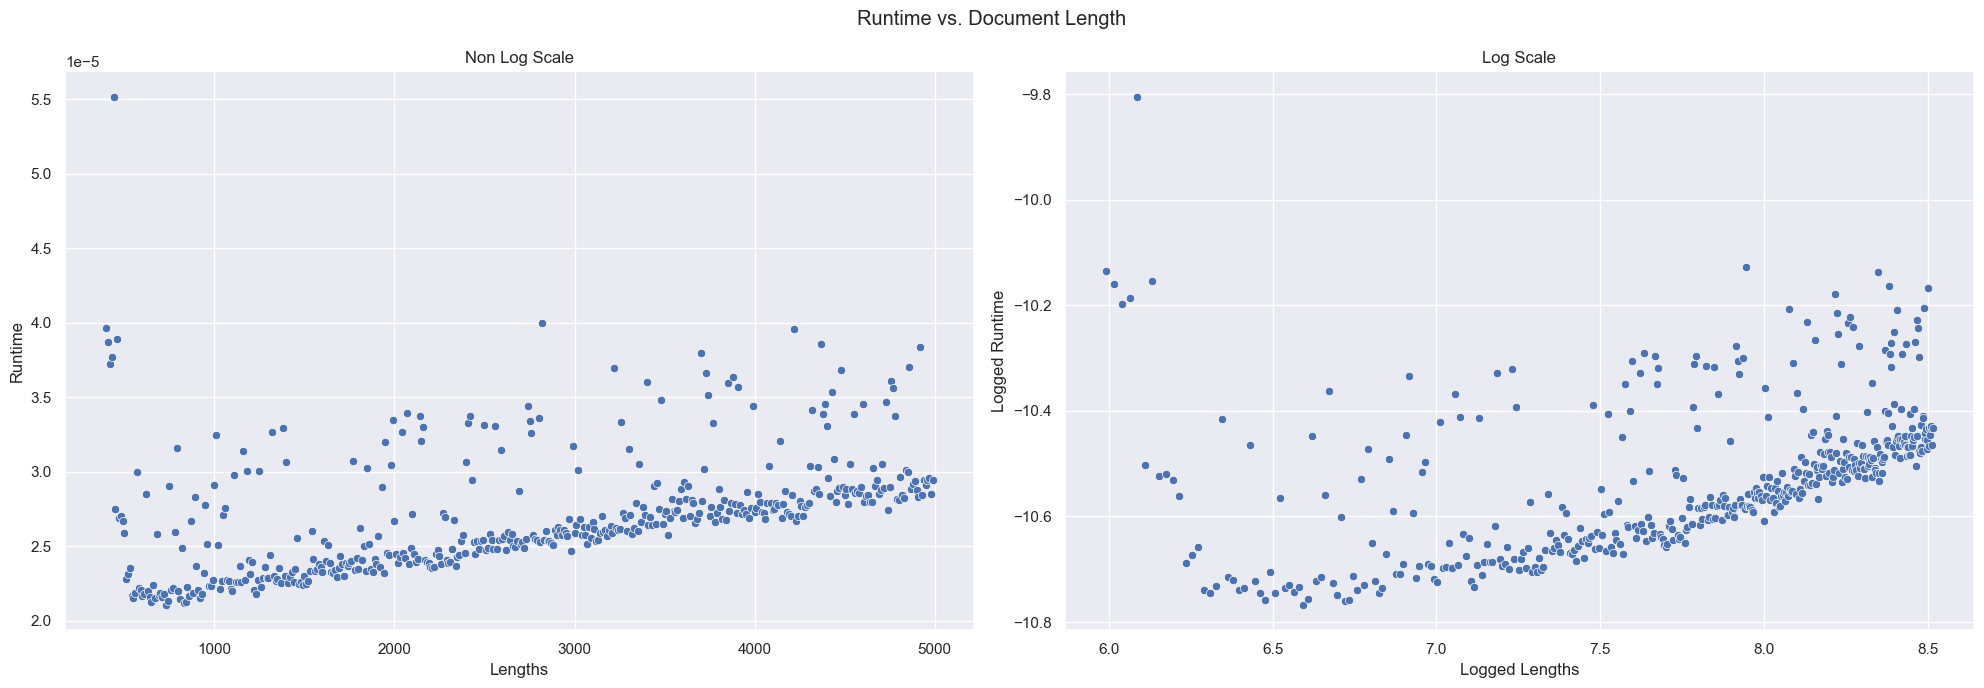

In [20]:
########################################################
# Plotting the results and summary staistics
########################################################

cos_np_xs = [x for x in range(400,5000,10)]
cos_np_logx = [np.log(x) for x in cos_np_xs]
cos_np_logy = [np.log(y) for y in cos_np_ys]


fig, axes = plt.subplots(1,2,figsize=(20,7),dpi=100)
fig.suptitle('Runtime vs. Document Length')

sns.scatterplot(ax=axes[0], x = cos_np_xs, y = cos_np_ys).set_title('Non Log Scale')
sns.scatterplot(ax=axes[1], x = cos_np_logx, y = cos_np_logy).set_title('Log Scale')

axes[0].set_ylabel('Runtime')
axes[1].set_ylabel('Logged Runtime')
axes[0].set_xlabel('Lengths')
axes[1].set_xlabel('Logged Lengths')
plt.tight_layout()


slope,intercept, r_value, p_value ,std_err = scipy.stats.linregress(cos_np_logx,cos_np_logy)
computer_constant = np.power(10,intercept)

print(f'The empirical Analysis of the Cosine Similarity with Numpy has yielded a value of {slope} for the slope and a value of {computer_constant} for the computer constant.')



## Analysis of the Results

The results vary from the theoretically determined worst caseruntime. In particular, the statistical analysis shows that the runtime for the examples in the empirical analysis is $O(n^{0.09})$ which is much smaller than the expected value. The comupter constant is 5.666576152416905e-12

There are several explanation of these results. Firstly, there might have been an issue with the time_it function used. In particular, the time_it function is best used on a programming language that is compiled (i.e. C language). In Python the code is a mix of compiled and interpreted which can lead to wrong results. Secondly, it is possible that the length of the documents is not large enough to determine the rumtime of the function in the limit. As such, a future report might replicate the results in C and use larger documents to determine the runtime more accurately.

# Section 4: Cosine Similarity with a bag of words Representation

In the following section the cosine similarity is analysed for bag of words representation. Hereby, the tokenized document is represented as a dictionary instead of a vector. The calculation of the cosine similarity is done mathematically in the same way as both implementations above.

## Description of the Algorithms:
In the following is a breakdown of the algorithm used in this section of the report:

$$\begin{aligned} 
&\text{line 1: assign value} = O(1) \\
&\text{line 1: assign value} = O(1) \\
&\text{line 1: for-loop over every item in dictionary 1} = O(n) \\
&\text{line 1: update value} = O(1) \\
&\text{line 1: update value} = O(1) \\
&\text{line 1: assign value} = O(1) \\
&\text{line 1: for-loop over every item in dictionary 2} = O(n) \\
&\text{line 1: update value} = O(1) \\
&\text{line 1: return analytical combination of values} = O(1) \\
\end{aligned}$$

As can be seen above, the cosine similarity from bag of words representation has a maximum time complexity of $O(n)$.

## Theoretical worst case runtime:
$$O(n)$$

In [21]:
#################################################################################
# Functions for Analysis 4: Cosine Similarity with bag of words representation
#################################################################################

def cosine_dic(dic1,dic2):
    numerator = 0
    denominator_a = 0
    for key1,val1 in dic1.items():
        numerator += val1*dic2.get(key1,0.0)
        denominator_a += val1*val1
    denominator_b = 0
    for val2 in dic2.values():
        denominator_b += val2*val2
    return numerator/math.sqrt(denominator_a*denominator_b)

In [22]:
#################################################################################
# Analysis 4: Cosine Similarity for sparse bag of words representations
#################################################################################

cos_sp_xs = [x for x in range(400,5000,10)]
cos_sp_ys = []

for i in range(400,5000,10):
    size = i

    doc1 = filtered_list[:size]
    doc2 = filtered_list[-size:]

    doc1_tok = tokenize(doc1)
    doc2_tok = tokenize(doc2)



    cos_sp_ys.append(timeit(cosine_dic,doc1_tok,doc2_tok)[1])


The empirical Analysis of the Cosine Similarity with bags of words has yielded a value of 1.0047200679779529 for the slope and a value of 3.3542259715236203e-16 for the computer constant.


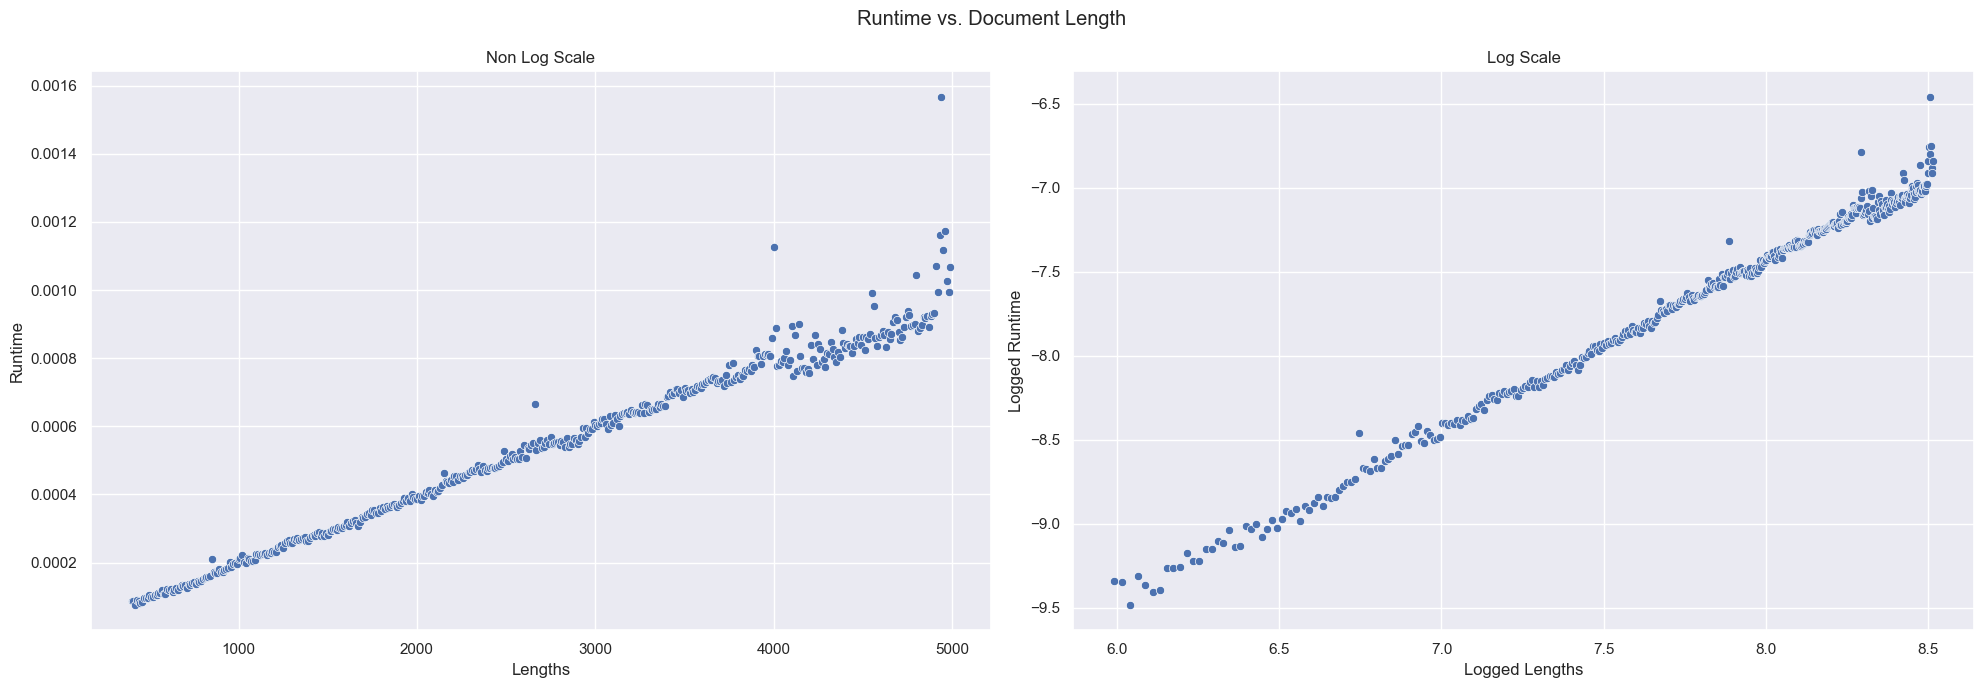

In [23]:
########################################################
# Plotting the results and summary staistics
########################################################

cos_sp_logx = [np.log(x) for x in cos_sp_xs]
cos_sp_logy = [np.log(y) for y in cos_sp_ys]


fig, axes = plt.subplots(1,2,figsize=(20,7),dpi=100)
fig.suptitle('Runtime vs. Document Length')

sns.scatterplot(ax=axes[0], x = cos_sp_xs, y = cos_sp_ys).set_title('Non Log Scale')
sns.scatterplot(ax=axes[1], x = cos_sp_logx, y = cos_sp_logy).set_title('Log Scale')

axes[0].set_ylabel('Runtime')
axes[1].set_ylabel('Logged Runtime')
axes[0].set_xlabel('Lengths')
axes[1].set_xlabel('Logged Lengths')
plt.tight_layout()


slope,intercept, r_value, p_value ,std_err = scipy.stats.linregress(cos_sp_logx,cos_sp_logy)
computer_constant = np.power(10,intercept)

print(f'The empirical Analysis of the Cosine Similarity with bags of words has yielded a value of {slope} for the slope and a value of {computer_constant} for the computer constant.')



## Analysis of the empirical results

The Cosine Similarity for bags of words representations has a theoretical temporal complexity of $O(n)$, similar to the Analysis of the Jaccard. The algorithm's empirical analysis complies with the time complexity theory. As seen above, the empirical Analysis of the Cosine Similarity sans Numpy has provided a value of value of 0.1004 for the slope and a value of 3.099734761661845e-16 for the computer constant. As a result, the cosine similarity has a $O(n^{1.004})$ time complexity in the emperical analysed cases, which is very close to the theoretical estimated time complexity of $O(n^1)$.

## Summary of all the analysis

,Jaccard,Naive Cosine,Cosine Numpy,Cosine Sparse,bag size
0,0.000087,0.000236,0.000040,0.000088,400
1,0.000079,0.000327,0.000039,0.000087,410
2,0.000081,0.000212,0.000037,0.000076,420
3,0.000096,0.000222,0.000038,0.000090,430
4,0.000093,0.000217,0.000055,0.000086,440
...,...,...,...,...,...
455,0.001065,0.002283,0.000029,0.001117,4950
456,0.001068,0.002315,0.000029,0.001172,4960
457,0.001039,0.002300,0.000030,0.001027,4970
458,0.001068,0.002292,0.000029,0.000994,4980


,Jaccard Log,Naive Cosine Log,Cosine Numpy Log,Cosine Sparse Log,logged bag size
0,-9.345703,-8.350322,-10.134423,-9.339743,5.991465
1,-9.441426,-8.026001,-10.158991,-9.347452,6.016157
2,-9.424389,-8.459546,-10.197461,-9.481980,6.040255
3,-9.248913,-8.412055,-10.185694,-9.310199,6.063785
4,-9.277849,-8.435969,-9.804917,-9.362912,6.086775
...,...,...,...,...,...
455,-6.844457,-6.082424,-10.445217,-6.797206,8.507143
456,-6.841690,-6.068170,-10.432349,-6.748922,8.509161
457,-6.869651,-6.074816,-10.428634,-6.881183,8.511175
458,-6.841886,-6.078459,-10.464500,-6.913737,8.513185


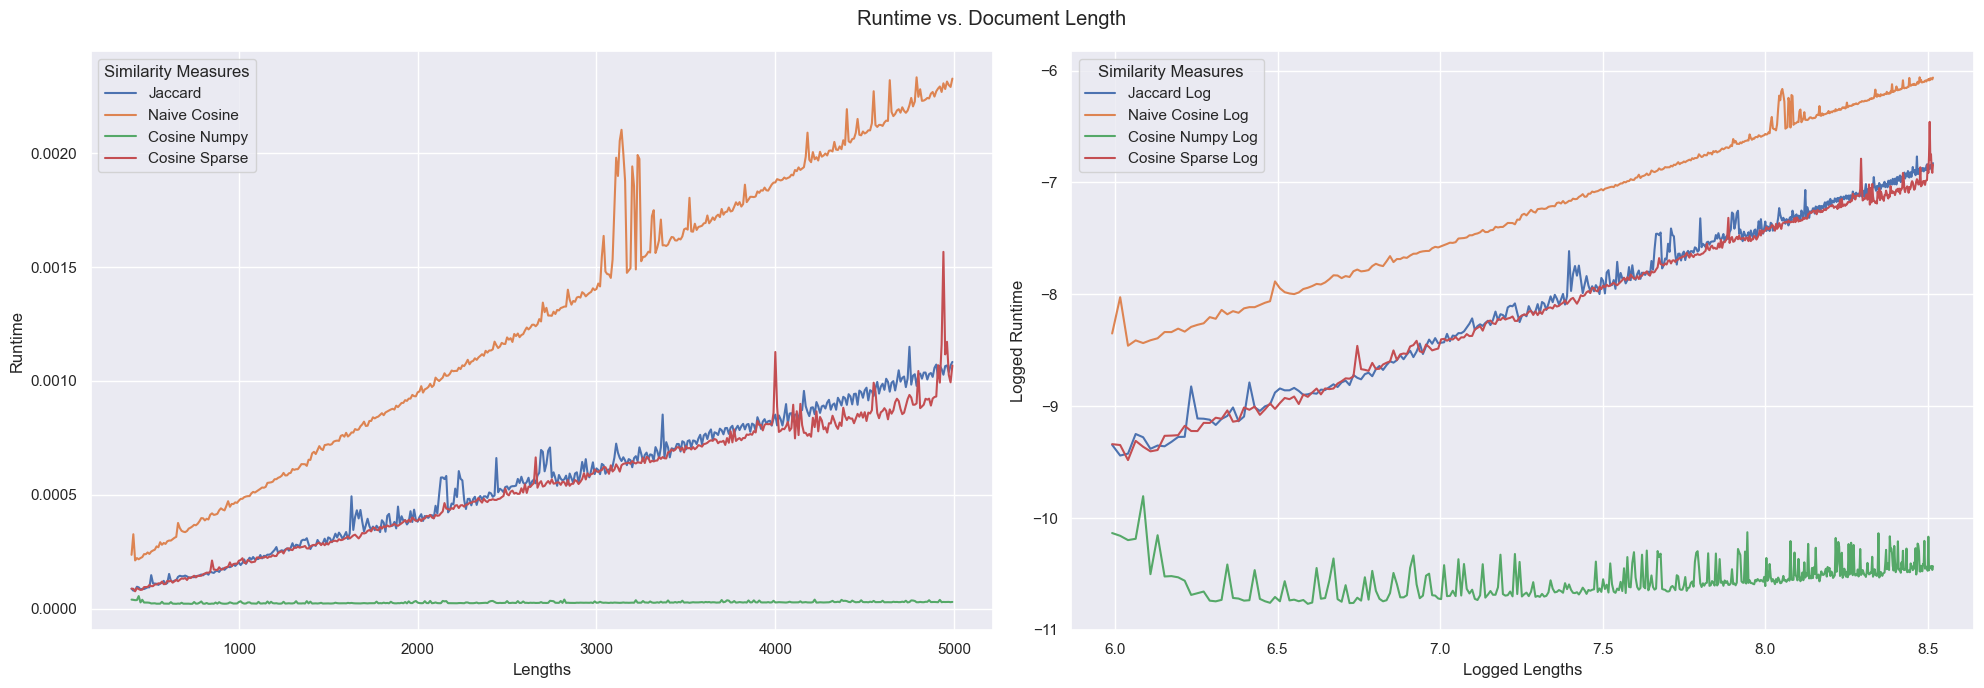

In [24]:
####################################################################
# Summary of all the experiments run
####################################################################


df = pd.DataFrame({'Jaccard': jac_ys,
                   'Naive Cosine': cos_ys,
                   'Cosine Numpy': cos_np_ys,
                   'Cosine Sparse': cos_sp_ys,
                    'bag size': jac_xs})


df_logged = pd.DataFrame({'Jaccard Log': jac_logy,
                   'Naive Cosine Log': cos_logy,
                   'Cosine Numpy Log': cos_np_logy,
                   'Cosine Sparse Log': cos_sp_logy,
                   'logged bag size': jac_logx})


dfm = df.melt('bag size', var_name='cols', value_name='vals')
dfm_logged = df_logged.melt('logged bag size', var_name='cols', value_name='vals')



fig, axes = plt.subplots(1,2,figsize=(20,7),dpi=100)
fig.suptitle('Runtime vs. Document Length')

sns.lineplot(ax=axes[0], x="bag size", y="vals", hue='cols', data=dfm)
sns.lineplot(ax=axes[1], x="logged bag size", y="vals", hue='cols', data=dfm_logged)

axes[0].set_ylabel('Runtime')
axes[1].set_ylabel('Logged Runtime')
axes[0].set_xlabel('Lengths')
axes[1].set_xlabel('Logged Lengths')
axes[0].legend(title='Similarity Measures')
axes[1].legend(title='Similarity Measures')

display(df, df_logged)


plt.tight_layout()

## Summary of the first four Sections

In the first four sections of this report, different similarity measures have been analysed with respect to their time complexity. Looking at the graph above it becomes clear that while the time complexity for all four implementations in $O(n)$ there are large differences between the effective runtimes of each algorithm. The worst algorithm is the naive cosine similarity without numpy, followed by the Jaccard similarity and sparse cosine similarity and the numpy implementation is the fastest of the four algrothms. It is remarkable that the fluctuations in the data are most prominent for the Cosine similarity with numpy. One explanation could be that the numpy implementation is more succeptable due to its much higher speed. It therefore become more difficult to time it precisely, because background activity on the local machine might take more time of the overall process than with other algorithms.

# Section 5: Runtime of All-Pairs Comparison for different Similarity Measures
For this section a function was written that calculates the similarity between a list of documents. The analysis consists of the timing of this function for different similarity measure functions. The functions below are tested in the all-pairs comparison. The final function that is being used is from the lecture (Barrett, 2022). The function from the lectures have been used as a sanity check to see if the results calculated with my function are identical to the results calculated with the function from the lecture.

In [25]:
#################################################################################
# Analysis 5: Functions used in the All-Pairs Comparison
#################################################################################

def Jaccards(dict_1, dict_2):
    '''
    calculates the Jaccards Similarity between two dictionaries
    '''
    intersection = {} 
    for item in dict_1.keys():
        if item in dict_2.keys():
            intersection[item]=min(dict_1[item],dict_2[item])
            
    intersectiontot = maketotal(intersection)
    union = maketotal(dict_1) + maketotal(dict_2) - intersectiontot
    
    return intersectiontot/union


def denominator(v1,v2):
    return np.sqrt(np.sum(v1)) * np.sqrt(np.sum(v2))


def cosine_np(v1,v2):
    num = np.dot(v1,v2)
    denom = denominator(v1,v2)

    cos = np.divide(num,denom)

    return round(cos,6)


def cosine_dic(dic1,dic2):
    numerator = 0
    dena = 0
    for key1,val1 in dic1.items():
        numerator += val1*dic2.get(key1,0.0)
        dena += val1*val1
    denb = 0
    for val2 in dic2.values():
        denb += val2*val2
    return numerator/math.sqrt(dena*denb)


############################################################################
# Functions used in lecture and lab session for validation 
############################################################################

def make_matrix(list_of_dicts):
    #first of all make a list of all of the features that occur in any document - these will be the dimensions of the matrix
    allfeatures={}    
    for docdict in list_of_dicts:
        for feat in docdict.keys():
            allfeatures[feat]=1
    
    dimensions=list(allfeatures.keys())
    #don't strictly need to sort it - but it is good practise to make sure it is reproducible
    sorted(dimensions)
    
    matrix=[]
    #each row in the matrix will be one of the dimensions
    for dimension in dimensions:
        row=[]
        #look up the appropriate value for each document
        for docdict in list_of_dicts:
            row.append(docdict.get(dimension,0)) #this will append the document's value if present, 0 otherwise
        matrix.append(row)
        
        
    return matrix

## it might be useful to be able to transpose a matrix so we can compare documents
def transpose(matrix):
    transposed=[]
    for i in range(0,len(matrix[0])):
        transposed.append([row[i] for row in matrix])
        
    return transposed

#call make_matrix on whatever variable holds your list of dictionaries representation of your documents


# print(amatrix)
# print(transpose(amatrix))      
#

def naiveCosine (a , b):
    num=0
    d1=0
    d2=0
    for i in range(len(a)):
        num += a [ i ] *b [ i ]
        d1 += a [ i ] *a [ i ]
        d2 += b [ i ] *b [ i ]
    return num / ( d1*d2 ) **0.5


In [26]:
#################################################################################
# Section 5: Comparison Function for All-Pairs Comparison
#################################################################################

def all_pairs_comparison(list_of_documents,func='Jaccard'):
    max_sim = tuple([0,0,0])
    min_sim = tuple([1,0,0])
    all_sims = []


    doc_1 = []
    doc_2 = []


    if func == 'Jaccard':
        for i in range(len(list_of_documents)):
            for j in range(len(list_of_documents)):
                
                # all_sims.append((f'Doc {i}',f'Doc {j}',Jaccards(list_of_documents[i],list_of_documents[j])))

                doc_1.append(f'{i+1}')
                doc_2.append(f'{j+1}')
                all_sims.append(Jaccards(list_of_documents[i],list_of_documents[j]))

                if i != j:
                    if max_sim[0] < Jaccards(list_of_documents[i],list_of_documents[j]):
                        max_sim = Jaccards(list_of_documents[i],list_of_documents[j]), i+1, j+1

                    elif min_sim[0] > Jaccards(list_of_documents[i],list_of_documents[j]):
                        min_sim = Jaccards(list_of_documents[i],list_of_documents[j]), i+1, j+1

        

        return max_sim, min_sim, [doc_1, doc_2, all_sims]



    elif func == 'Cosine Numpy': # change back to cosine_np
        for i in range(len(list_of_documents)):
            for j in range(len(list_of_documents)):
                doc_1.append(f'{i+1}')
                doc_2.append(f'{j+1}')
                all_sims.append(cosine_np(list_of_documents[i],list_of_documents[j]))

                if i != j:
                    if max_sim[0] < cosine_np(list_of_documents[i],list_of_documents[j]):
                        max_sim = cosine_np(list_of_documents[i],list_of_documents[j]), i+1, j+1

                    elif min_sim[0] > cosine_np(list_of_documents[i],list_of_documents[j]):
                        min_sim = cosine_np(list_of_documents[i],list_of_documents[j]), i+1, j+1

        return max_sim, min_sim, [doc_1, doc_2, all_sims]



    elif func == 'Cosine Dense': 

        for i in range(len(list_of_documents)):
            for j in range(len(list_of_documents)):
                doc_1.append(f'{i+1}')
                doc_2.append(f'{j+1}')
                all_sims.append(naCosine(list_of_documents[i],list_of_documents[j]))

                if i != j:
                    if max_sim[0] < naCosine(list_of_documents[i],list_of_documents[j]):
                        max_sim = naCosine(list_of_documents[i],list_of_documents[j]), i+1, j+1

                    elif min_sim[0] > naCosine(list_of_documents[i],list_of_documents[j]):
                        min_sim = naCosine(list_of_documents[i],list_of_documents[j]), i+1, j+1

        return max_sim, min_sim, [doc_1, doc_2, all_sims]

    

    elif func == 'Cosine Sparse':
        for i in range(len(list_of_documents)):
            for j in range(len(list_of_documents)):

                doc_1.append(f'{i+1}')
                doc_2.append(f'{j+1}')
                all_sims.append(cosine_dic(list_of_documents[i],list_of_documents[j]))

                if i != j:
                    if max_sim[0] < cosine_dic(list_of_documents[i],list_of_documents[j]):
                        max_sim = cosine_dic(list_of_documents[i],list_of_documents[j]), i+1, j+1

                    elif min_sim[0] > cosine_dic(list_of_documents[i],list_of_documents[j]):
                        min_sim = cosine_dic(list_of_documents[i],list_of_documents[j]), i+1, j+1
                        
        return max_sim, min_sim, [doc_1, doc_2, all_sims]

The algorithm takes a function and document list. The nested for loop compares every document against each other in the list. In addition the maximum and minimum value are being returned as well as a list of list that will be used in a dataframe to display the results (see below). The theoretical worse case runtime for this algorithm is $O(n^2)$ if one function is selected and $O(n^3)$ if all functions would be run sequentially.

In [27]:
########################################################################
# Analysis 5a: Confirming the functioning of all similarity measures
########################################################################

documents = []
vectors = []

length = 5

for i in range(5):
    documents.append(tokenize(filtered_list[:length]))

    length += random.randint(1,10)


for i in range(len(documents)):
    vectors.append(convert_to_vectors(documents[i],documents[-1])[0])

max_sim, min_sim, jac_results = all_pairs_comparison(documents,func='Jaccard')
max_sim, min_sim, cos_dense_results = all_pairs_comparison(vectors,func='Cosine Dense')
max_sim, min_sim, cos_numpy_results = all_pairs_comparison(vectors,func='Cosine Numpy')
max_sim, min_sim, cos_sparse_results = all_pairs_comparison(documents,func='Cosine Sparse')


reference = []
amatrix=make_matrix(documents)

for i in range(len(vectors)):
    for j in range(len(vectors)):
        reference.append(naiveCosine(transpose(amatrix)[i],transpose(amatrix)[j]))


For simplicity the analysis above creates 5 documents and calculates the similarity for all similarity measures used. The results are displayed in the following table.

In [28]:
datafm = pd.DataFrame({'# Document 1': jac_results[0],
                       '# Document 2': jac_results[1],
                       'Jaccard Values': jac_results[2],
                       'Cosine Dense Values': cos_dense_results[2],
                       'Cosine Numpy Values': cos_numpy_results[2],
                       'Cosine Sparse Values': cos_sparse_results[2],
                       'References Method from Lecture': reference})


with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 4,
                       ):

    display(datafm)            

,# Document 1,# Document 2,Jaccard Values,Cosine Dense Values,Cosine Numpy Values,Cosine Sparse Values,References Method from Lecture
0,1,1,1.0000,1.0000,1.0000,1.0000,1.0000
1,1,2,0.8333,0.9129,0.9129,0.9129,0.9129
2,1,3,0.3571,0.5976,0.5976,0.5976,0.5976
3,1,4,0.2778,0.5270,0.5270,0.5270,0.5270
4,1,5,0.2000,0.4472,0.4472,0.4472,0.4472
5,2,1,0.8333,0.9129,0.9129,0.9129,0.9129
6,2,2,1.0000,1.0000,1.0000,1.0000,1.0000
7,2,3,0.4286,0.6547,0.6547,0.6547,0.6547
8,2,4,0.3333,0.5774,0.5774,0.5774,0.5774
9,2,5,0.2400,0.4899,0.4899,0.4899,0.4899


The results above confirm that the measures are resulting in the correct results. All Cosine values are identical. The values for the Jaccard similarity are not the same but the general ordering is the same.

## Timing Analysis fo the All-Pairs Comparison
In the analysis above documents of different length are being created for each run of the analysis. Overall, there are 23 sample runs with document number ranging from 1 to 67. These number have been selected arbitrarily to create enough data for a reliable analysis and plot. For testing the functionality of the algorithm, lower values are recommended as the time to run the analysis is realatively high. In each run the documents (or its vector representation) are used to calculate the time it takes for an all pair-comparison. The values obtained from the timeit function are then stored in a dataframe (see below). The dataframe is then used to plot the results.

In [29]:
########################################################################
# Analysis 5b: Timing of the All-Pairs Comparison for all for Measures
########################################################################

no_doc = []
t_jac = []
t_cos_d = []
t_cos_s = []
t_cos_na = []

for i in range(1,70,3):
    no_doc.append(i)

    documents = []
    vectors = []

    length = 5

    for j in range(i):
        documents.append(tokenize(filtered_list[:length]))

        length += random.randint(1,10)


    for k in range(len(documents)):
        vectors.append(convert_to_vectors(documents[k],documents[-1])[0])

    t_jac.append(timeit(all_pairs_comparison,documents,func='Jaccard',repeats=50)[1])
    t_cos_d.append(timeit(all_pairs_comparison,vectors,func='Cosine Numpy',repeats=50)[1])
    t_cos_na.append(timeit(all_pairs_comparison,vectors,func='Cosine Dense',repeats=50)[1])
    t_cos_s.append(timeit(all_pairs_comparison,documents,func='Cosine Sparse',repeats=50)[1])


Text(0, 0.5, 'Runtime')

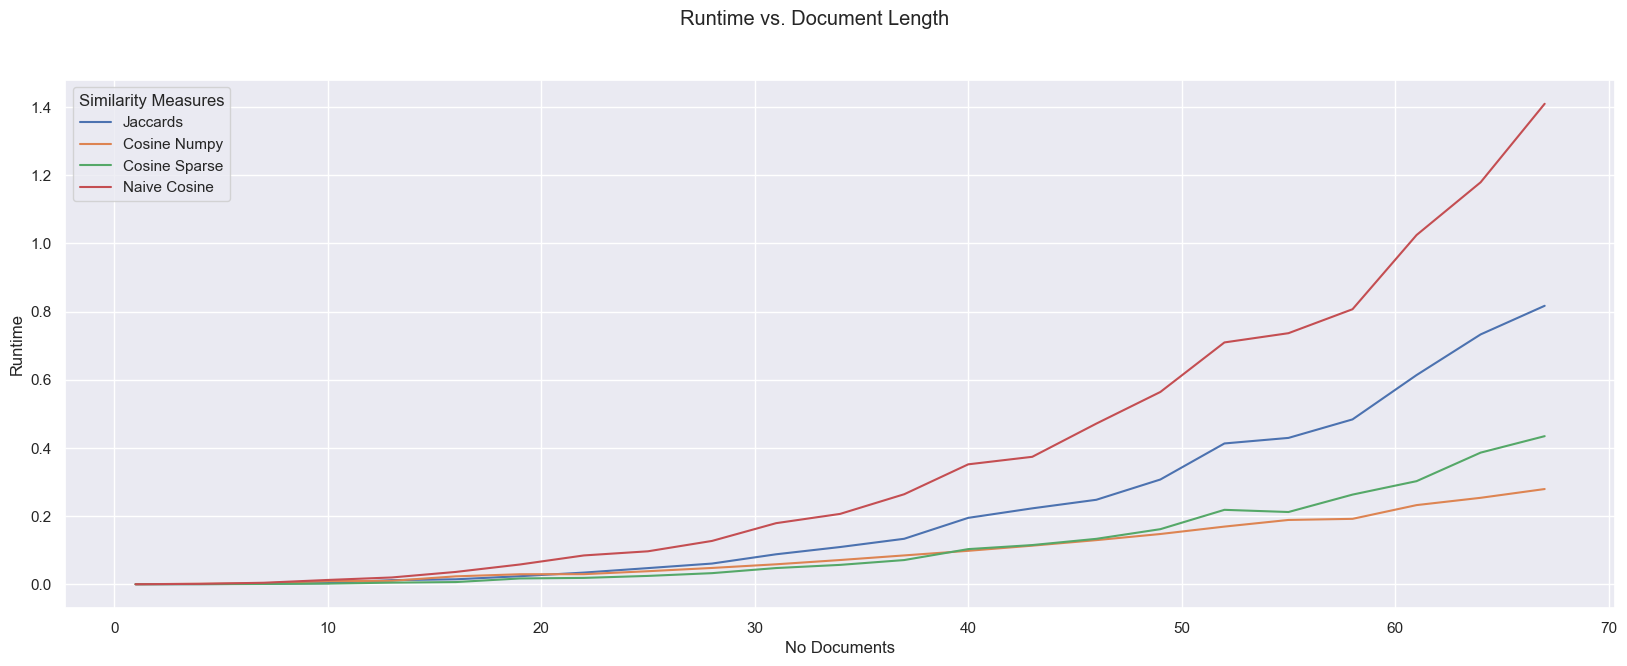

In [30]:
df_all_pairs_time = pd.DataFrame({'No Documents': no_doc,
                                 'Jaccards': t_jac,
                                 'Cosine Numpy': t_cos_d,
                                 'Cosine Sparse': t_cos_s,
                                 'Naive Cosine': t_cos_na})

dfm = df_all_pairs_time.melt('No Documents', var_name='cols', value_name='vals')

fig, axes = plt.subplots(1,figsize=(20,7),dpi=100)
fig.suptitle('Runtime vs. Document Length')

sns.lineplot(x="No Documents", y="vals", hue='cols', data=dfm)


axes.legend(title='Similarity Measures')
axes.set_ylabel('Runtime')

In [31]:
log_com_jac = [np.log(x) for x in t_jac]
log_com_cos_d = [np.log(x) for x in t_cos_d]
log_com_cos_s = [np.log(x) for x in t_cos_s]
log_com_cos_na = [np.log(x) for x in t_cos_na] 

value_list = [log_com_jac,log_com_cos_s,log_com_cos_d,log_com_cos_na]

b = [np.log(x) for x in no_doc]

measures = ['Jaccards', 'Cosine Numpy', 'Cosine Sparse', 'Cosine Naive']
slopes = []
intercepts = []
time = []

for i in range(len(value_list)):
    slope,intercept, r_value, p_value ,std_err = scipy.stats.linregress(b,value_list[i])
    slopes.append(slope)
    intercepts.append(np.power(10,intercept))
    time.append(np.power(10,intercept) * 200000**slope)


slopes_df = pd.DataFrame({'Measures': measures,
                            'O(n)': slopes,
                            'constants': intercepts,
                            'times': time})


Above are the time complexites for the different measures calculated. Below these results are displayed.

,Measures,O(n),constants,times
0,Jaccards,2.674174,2.607118e-12,390.875680
1,Cosine Numpy,2.724133,3.935714e-13,108.575860
2,Cosine Sparse,1.895316,5.119963e-10,5.706798
3,Cosine Naive,2.492101,5.430550e-11,882.154352


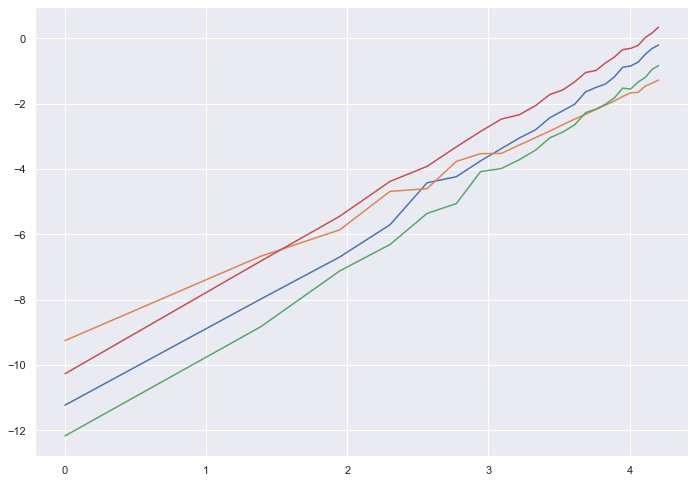

In [32]:
display(slopes_df)

plt.plot(b, log_com_jac)
plt.plot(b, log_com_cos_d)
plt.plot(b, log_com_cos_s)
plt.plot(b, log_com_cos_na)



## Analysis of the Results from Section 5:

The results of the analysis are displayed above. The graph shows that the naive cosine implementation has the worst time complexity followed by the Jaccard implementation, the sparse implementation and lastly the numpy implementation. The analysis has uncovered that for low numbers of documents all four implementations yield very similar results. However, starting from 20 documents the results spread out and it becomes clear that especially the dense cosine implementation without numpy is a poor choice for large numbers of documents.

The results of the time complexity analysis yield unexpected results. The Jaccard implementation has a time complexity of $O(n^{2.674})$, the cosine implementation with Numpy has a time complexity of $O(n^{2.724})$, the sparse Cosine implementation has a time complexity of $O(n^{1.895})$ and lastly the naive cosine implementation has a time complexity of $O(n^{2.492})$. These results are unexpected because they are not in line with the previous results form earlier analysis that demonstated that the naive cosine implementation is the slowest implementation for large numbers of documents and the numpy implementation is the fastest implementation for large numbers of documents. Unfortunately, it was not possible to determine the exact reason for this divergence and future work needs to be conducted to determine the exact origin. For the purposes of this report the results will be used for further analysis to provide a proof-of-technical expertiese. 

## Theoretical Runtime for 200K documents:
For 200000 documents the runtime can be assumed to be asymptotic. Therefore, given the values from above it would be much more efficient to use the sparse implementation as it has a runtime of $O(n^{1.98})$ Calculations for the time it would take result in a runtime of 8 seconds (see table above). This is impossible and hints at an error in the calculation which unfortunately could not be identified in due time. 

# Section 6: MapReduce Implementation of the All-Pairs Comparison
## MapReduce Paradigm Explanation:

MapReduce is a programming model and an associated implementation for processing and generating large data volumes with a parallel, distributed algorithm (in reality on a distributed comupter cluster).

The MapReduce model consists of two main functions:

- Map: This function takes a set of key-value pairs as input and processes each input pair to generate a set of intermediate key-value pairs. The map function is applied to each input pair independently, in parallel.
- Reduce: This function takes the intermediate key-value pairs produced by the map function as input and combines all pairs with the same key to produce a set of output key-value pairs. The reduce function is applied to the intermediate pairs in a group-by-key fashion, in parallel.

MapReduce is useful for distributed processing of large data sets because it allows the programmer to specify the computation in terms of map and reduce functions, which are then executed in parallel across a cluster of machines or computer cores. This makes it possible to scale out the computation to handle very large data sets, as the processing can be distributed across many machines. In the following section an implementation of MapReduce is used to use the cores in this local machine to process the all-pairs comparison.

In [33]:
from collections import defaultdict
import multiprocess
from multiprocess import Pool # multiprocess is used to allow for multicore applications to run in jupyter notebooks.

For the analysis 50 documents are created and vectorized.

In [34]:
##################################################################
# Creating Documents
##################################################################

documents = []
vectors = []
length = 50

for i in range(50):
    documents.append(tokenize(filtered_list[:length]))
    length += random.randint(1,10)

for i in range(len(documents)):
    vectors.append(convert_to_vectors(documents[i],documents[-1])[0])


In [35]:
##################################################################
# MapReduce Functions functions
##################################################################

def mapper(document):
    '''
    the mapper function maps values to associated key
    '''
    output = []
    for num in document:
        output.append((str(num[0]),num))
         
    return output

def mapreduce(doc, mapping_function, reducing_function, mapprocesses = 1,reduceprocesses = 1):
    outputs = []
    collector = defaultdict(list)  # stores intermediate results
                                 
    mappool = Pool(processes = mapprocesses) # number of allocated mapping processes
    
    
    results_mapping = mappool.map(mapping_function, doc) # mapping the documents
    mappool.close()

    for mapresult in results_mapping:
        for key, value in mapresult:     #pass each input to the mapper function 
            collector[key].append(value)     

    reducepool = Pool(processes = reduceprocesses) # number of allocated reducing processes
    
    results_reduce = reducepool.map(reducing_function, collector.items()) # reducing the documents
    reducepool.close()
    
    # collect results and assemble output
    for interim_result in results_reduce:
        outputs += interim_result
        
    return outputs

def all_pairs_mapreduce(documents, mapping_function, reducing_function, mp = 1, rp = 1):
    
    pairs = []
    
    for i in range(len(documents)):
        pair=[]
        for j in range(len(documents)):
            pair.append([i,j])
            
        pairs.append(pair)    

    return mapreduce(pairs, mapping_function, reducing_function, mp, rp)

In [36]:
##################################################################
# Reducer functions
##################################################################

def red_jac(item):
    out = []
    key, values = item

    for value in values:
        jaccard_vals = Jaccards(documents[value[0]],documents[value[1]])
        out.append(round(jaccard_vals,3)) 

    return out


def red_cos(item):
    out = []
    key, values = item

    for value in values:
        cosine_vals = naCosine(vectors[value[0]],vectors[value[1]])
        out.append(round(cosine_vals,3))

    return out

## Verification of the Results:
In the following section the mapreduce results are checked against the similarity measures of the corresponding non-parallelised function `all_pairs_comparison`.

In [37]:
jac_mapreduce_values = all_pairs_mapreduce(documents=documents,mapping_function=mapper, reducing_function=red_jac) 
cos_mapreduce_values = all_pairs_mapreduce(documents=documents,mapping_function=mapper, reducing_function=red_cos)

jac_allpairs_values = all_pairs_comparison(documents,func='Jaccard')
cos_allpairs_values = all_pairs_comparison(vectors,func='Cosine Dense')


In [38]:
doc_1 = []
doc_2 = []

for i in range(len(documents)):
    for j in range(len(documents)):
        doc_1.append(str(i))
        doc_2.append(str(j))

df_mapreduce = pd.DataFrame({'Document 1': doc_1,
                            'Document 2': doc_2,
                            'Jaccards MapReduce': jac_mapreduce_values,
                            'Jaccard Sequential': jac_allpairs_values[2][2],
                            'Cosine MapReduce':cos_mapreduce_values,
                            'Cosine Sequential': cos_allpairs_values[2][2]})

In [39]:
with pd.option_context('display.max_rows', 30,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):

    display(df_mapreduce) 

,Document 1,Document 2,Jaccards MapReduce,Jaccard Sequential,Cosine MapReduce,Cosine Sequential
0,0,0,1.000,1.000,1.000,1.000
1,0,1,0.980,0.980,0.990,0.990
2,0,2,0.847,0.847,0.921,0.921
3,0,3,0.833,0.833,0.913,0.913
4,0,4,0.806,0.806,0.898,0.898
...,...,...,...,...,...,...
2495,49,45,0.910,0.910,0.954,0.954
2496,49,46,0.944,0.944,0.972,0.972
2497,49,47,0.976,0.976,0.988,0.988
2498,49,48,0.997,0.997,0.998,0.998


The table above shows that the results for the mapreduce paradigm and the results for the `all_pairs_function` are the same. Therefore the analysis can be continued.

## Time Comparison for the MapReduce and `all_pairs_function`
In the last section of the report different document lengths are compared and timed using the mapreduce function and the all_pairs_function. Overall three test will be performed. Firstly, a small number of documents will be passed to the functions (n = 10),  secondly a large number of documents will be passed to the functions (n = 50), and lastly a very large number of documents will be passed to the functions (n = 100). In the first analysis the experiment shows that for very small number of documents the sequential approach is faster. This is hypothesized because for few documents the communication overhang take a significant amount of time and therefore the efficiency of the entire operation is severely compromised. For large number of documents the the parallisation is on the other hand more pronounced and time gain become very apparent for 100 documents.

In [40]:
import time # I sometimes ran into trouble with the time module that required reloading

##################################################################
# Creating Documents
##################################################################

documents = []
vectors = []

length = 50

for i in range(10):
    documents.append(tokenize(filtered_list[:length]))

    length += random.randint(1,10)

for i in range(len(documents)):
    vectors.append(convert_to_vectors(documents[i],documents[-1])[0])


mr_timeit_10_jac = timeit(all_pairs_mapreduce,documents=documents,mapping_function=mapper, reducing_function=red_jac,repeats=10)[1]
mr_timeit_10_cos = timeit(all_pairs_mapreduce,documents=vectors,mapping_function=mapper, reducing_function=red_cos,repeats=10)[1]

seq_timeit_10_jac = timeit(all_pairs_comparison,documents,func='Jaccard',repeats=10)[1]
seq_timeit_10_cos = timeit(all_pairs_comparison,vectors,func='Cosine Dense',repeats=10)[1]



print(f'MapReduce Jac: {mr_timeit_10_jac}; MapReduce Cos: {mr_timeit_10_cos}')
print(f'Sequential Jac: {seq_timeit_10_jac};Sequential Cos: {seq_timeit_10_cos}')

MapReduce Jac: 0.03424041271209717; MapReduce Cos: 0.04049110412597656
Sequential Jac: 0.00929868221282959;Sequential Cos: 0.01265718936920166


For very low document numbers the MapReduce implementation the sequential implementation is faster. This is expected as the MapReduce implementation comes with a communication cost that makes it very expensive to execute for low numbers of documents.

In [41]:
##################################################################
# Creating Documents
##################################################################

documents = []
vectors = []

length = 50

for i in range(50):
    documents.append(tokenize(filtered_list[:length]))

    length += random.randint(1,10)

for i in range(len(documents)):
    vectors.append(convert_to_vectors(documents[i],documents[-1])[0])

mr_timeit_50_jac = timeit(all_pairs_mapreduce,documents=documents,mapping_function=mapper, reducing_function=red_jac,repeats=10)[1]
mr_timeit_50_cos = timeit(all_pairs_mapreduce,documents=vectors,mapping_function=mapper, reducing_function=red_cos,repeats=10)[1]

seq_timeit_50_jac = timeit(all_pairs_comparison,documents,func='Jaccard',repeats=10)[1]
seq_timeit_50_cos = timeit(all_pairs_comparison,vectors,func='Cosine Dense',repeats=10)[1]

print(f'MapReduce Jac: {mr_timeit_50_jac}; MapReduce Cos: {mr_timeit_50_cos}')
print(f'Sequential Jac: {seq_timeit_50_jac};Sequential Cos: {seq_timeit_50_cos}')

MapReduce Jac: 0.2917618274688721; MapReduce Cos: 0.5551221370697021
Sequential Jac: 0.6470768928527832;Sequential Cos: 0.7354331016540527


The second analysis above demonstrates that for 50 documents we can see that the MapReduce implementation is more efficient and faster than the sequential implementation from above. Therefore we can analyse the best settings for the MapReduce implementation with larger numbers than 50 documents. In the following example this report looks at 100 document and analyses the best number of mapper and reducer that will yield the shortest runtime. 

In [42]:
##################################################################
# Creating Documents
##################################################################

documents = []
vectors = []

length = 50

for i in range(100):
    documents.append(tokenize(filtered_list[:length]))

    length += random.randint(1,10)

for i in range(len(documents)):
    vectors.append(convert_to_vectors(documents[i],documents[-1])[0])


#################################################################
# Analysis of different reducer and mapper numbers
#################################################################

values = []
mr_jac_all_values = []
mr_cos_all_values = []

rps = [1,3,5,7,10,12,15]
mps = [1,3,5,7,10,12,15]

for i in rps:
    for j in mps:
        mr_timeit_100_jac = timeit(all_pairs_mapreduce,documents=documents,mapping_function=mapper, reducing_function=red_jac,rp=i, mp = j, repeats=5)[1]
        mr_timeit_100_cos = timeit(all_pairs_mapreduce,documents=vectors,mapping_function=mapper, reducing_function=red_cos,rp=i, mp = j, repeats=5)[1]

        values.append((f'rp = {i}',f'rm = {j}'))
        mr_jac_all_values.append(mr_timeit_100_jac)
        mr_cos_all_values.append(mr_timeit_100_cos)



seq_timeit_100_jac = timeit(all_pairs_comparison,documents,func='Jaccard',repeats=5)[1]
seq_timeit_100_cos = timeit(all_pairs_comparison,vectors,func='Cosine Dense',repeats=5)[1]


df_mapreduce_processes = pd.DataFrame({'Value Combinations': values,
                                      'Time Jac': mr_jac_all_values,
                                      'Time Cos': mr_cos_all_values})


In [43]:
#################################################################
# Print Table for the MapReduce Results
#################################################################

df_jac_sorted = df_mapreduce_processes.sort_values('Time Jac')
df_cos_sorted = df_mapreduce_processes.sort_values('Time Cos')


display_short = True

with pd.option_context('display.max_rows', 10,
                       'display.max_columns', None,
                       'display.precision', 4,
                       ):

    if display_short:
        print(f'Reference Values from the sequential processes:\nCosine: {seq_timeit_100_cos} - Jaccard {seq_timeit_100_jac}')
        display(df_jac_sorted)
        display(df_cos_sorted)

    else:
        print(f'Reference Values from the sequential processes:\nCosine: {seq_timeit_100_cos} - Jaccard {seq_timeit_100_jac}')
        df1_styler = df_jac_sorted.style.set_table_attributes("style='display:inline'").set_caption('Jaccards')
        df2_styler = df_cos_sorted.style.set_table_attributes("style='display:inline'").set_caption('Cosine')
        display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

Reference Values from the sequential processes:
Cosine: 4.870266771316528 - Jaccard 3.30911808013916


,Value Combinations,Time Jac,Time Cos
23,"(rp = 7, rm = 5)",0.4301,0.5849
31,"(rp = 10, rm = 7)",0.4384,0.5908
30,"(rp = 10, rm = 5)",0.4391,0.5871
37,"(rp = 12, rm = 5)",0.4409,0.5769
32,"(rp = 10, rm = 10)",0.4463,0.6424
...,...,...,...
2,"(rp = 1, rm = 5)",1.4003,2.2558
6,"(rp = 1, rm = 15)",1.4042,2.2577
4,"(rp = 1, rm = 10)",1.4130,2.2309
5,"(rp = 1, rm = 12)",1.4331,2.2773


,Value Combinations,Time Jac,Time Cos
37,"(rp = 12, rm = 5)",0.4409,0.5769
23,"(rp = 7, rm = 5)",0.4301,0.5849
30,"(rp = 10, rm = 5)",0.4391,0.5871
31,"(rp = 10, rm = 7)",0.4384,0.5908
33,"(rp = 10, rm = 12)",0.4862,0.5912
...,...,...,...
4,"(rp = 1, rm = 10)",1.4130,2.2309
2,"(rp = 1, rm = 5)",1.4003,2.2558
6,"(rp = 1, rm = 15)",1.4042,2.2577
5,"(rp = 1, rm = 12)",1.4331,2.2773


## Discussions of the MapReduce Experiment
The results above clearly show the the parallelised implementation with MapReduce is much more efficient and faster than the single-threaded implementation with the `all_pairs_comparison` function. Furthermore, the table above show that for the Jaccards similarity algorithm a setup with seven reducer functions and five mapper function yields the most efficient results. For the Cosine similarity algorithm, interestingly, 12 reducer functions and five mapper functions yield the most efficient results. However, other combinations of reducer functions and mapper functions also yield good results and the setup will also heavily depend on the number of cores available or the number of nodes available in the distributed cluster. In different runs three mapper function yielded marginally better results. Most interestingly, the experiment was able to demonstrate the difference in performance as well as the advantages of both implementation in different environments (i.e. low document number and high document number).


# Section 7: Conclusion and final Remarks
This report analysed the theoretical runtime of different algorithms to identify the best algorithm to perform a similarity analysis between different document lenghts as well as number of documents. In the first sections of the report it was established that a dense vector implementation with numpy is the most efficient implementation. This is not surprising as numpy code is written directly in the C programming language with provides very fast implementation times as a low-level language. This is especially true when comparing it to a general purpose python code. In the first analysis it was further discovered that both the Jaccards algorithm and the sparse cosine implementation yield very similar results. The naive Cosine implementation working on vectors was found to be the worst performer. 
In the second analysis all implementations were tested in their ability to calculate the similarity between sets of documents. Here the sparse cosine implementation was found the fastest with the Jaccards algorithm showing considerable time increases. This was puzzling and no conclusion could be drawn on the origin of this ideosyncratic behavior. 
Lastly, it was demonstrated that a multiprocessing implementation is only faster for sets of documents that have reached a sufficient size. However, once the size threshold is reached the multiprocessing implementation is much faster than its sequential counterpart. Overall the report highlights the importance of runtime analyses for large scale projects such as plagiarism checking. 

# Sources:

Barrett, A.: Lecture on MapReduce Paradigm, 2022, Sussex, UK